<a href="https://colab.research.google.com/github/skyshine460/GHG_Direct_Emissions/blob/main/submit_ghg27_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 初期設定

In [ ]:
pip install pygeohash

  Preparing metadata (setup.py) ... done
  Created wheel for pygeohash: filename=pygeohash-1.2.0-py2.py3-none-any.whl size=6153 sha256=83d30e789bf2fa08d2ec0092a1063135554606b96d6b2bcefbe2e5be5965a0cb
  Stored in directory: /root/.cache/pip/wheels/28/ec/b6/beadf7295a623f528507691fb0d471b50d064ae9bbad420b8f
Successfully built pygeohash


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.3 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import math

import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

import gc
gc.collect()

import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# データの読み込み

In [ ]:
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/train.csv')

# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/test.csv')

In [ ]:
# 各カラムのデータ型と欠損値（nan）を表示
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    print(df.shape)
    return info_df

def normal_distribution_fit(df, col):

    # 正規分布のフィッティング
    from scipy.stats import norm
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # カテゴリデータかどうかを判定
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        # カテゴリデータの場合
        sns.countplot(x=df[col], ax=ax[0])
        ax[0].set_title('Bar Plot of Categorical Data')
    else:
        # 数値データの場合
        sns.histplot(df[col], kde=True, stat='density', ax=ax[0])
        # 正規分布のフィット
        sns.histplot(df[col], stat='density', ax=ax[0], bins=30)
        x = np.linspace(df[col].min(), df[col].max(), 100)
        ax[0].plot(x, norm.pdf(x, df[col].mean(), df[col].std()), color='red')
        ax[0].set_title('Histogram with Normal Distribution Fit')

        # Q-Qプロット
        stats.probplot(df[col], plot=ax[1])
        ax[1].set_title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

    # 数値データの場合のみ歪度と尖度を計算
    if df[col].dtype != 'object' and df[col].dtype.name != 'category':
        print(f"Skewness: {df[col].skew()}")
        print(f"Kurtosis: {df[col].kurt()}")

    # 欠損値の確認
    print(f"isnull: {df[col].isnull().sum()}")

In [ ]:
information_df(train_df)

(4655, 22)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,4655,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
FacilityName,object,0,4531,"[VISCOFAN USA INC, CORNWELL STATION - DOMINION..."
Latitude,float64,102,4492,"[40.141389, 38.475305, 39.29982, 35.490363, 41..."
Longitude,float64,102,4486,"[-87.581111, -81.278957, -80.85717, -119.04295..."
LocationAddress,object,179,4435,"[915 N MICHIGAN AVE, 200 RIVER HAVEN ROAD, 304..."
City,object,0,2588,"[DANVILLE, CLENDENIN, GREENWOOD, BAKERSFIELD, ..."
State,object,0,54,"[IL, WV, CA, OH, OK, NM, TN, LA, TX, IN, NC, M..."
ZIP,object,0,3758,"[61832, 25045-9304, 26415, 93308, 441031047, 7..."
County,object,70,1165,"[VERMILION, KANAWHA, RITCHIE, KERN, CUYAHOGA, ..."
FIPScode,float64,73,1646,"[17183.0, 54039.0, 54085.0, 6029.0, 39035.0, 4..."


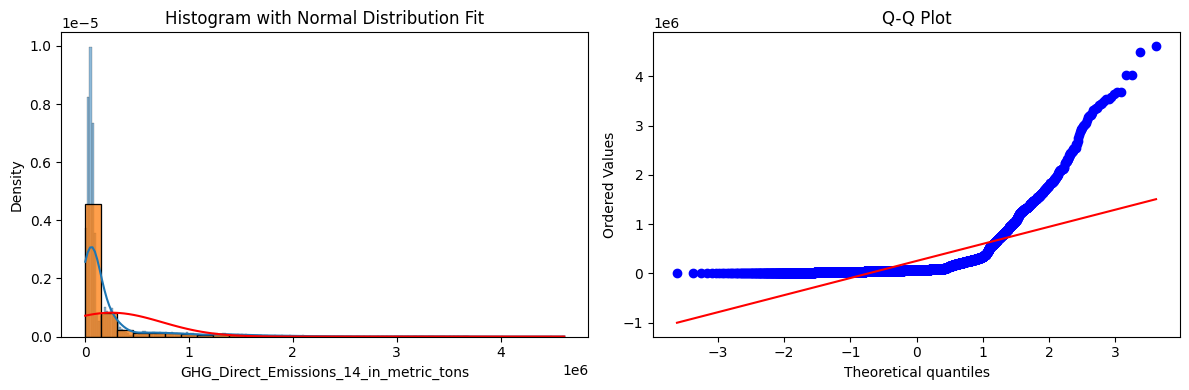

Skewness: 3.6649052199295338
Kurtosis: 16.560320863687245
isnull: 0


In [ ]:
normal_distribution_fit(train_df, 'GHG_Direct_Emissions_14_in_metric_tons')

評価指標はRMSLEであり、ヒストグラムも右に裾が長いグラフなので、対数変換を行う。

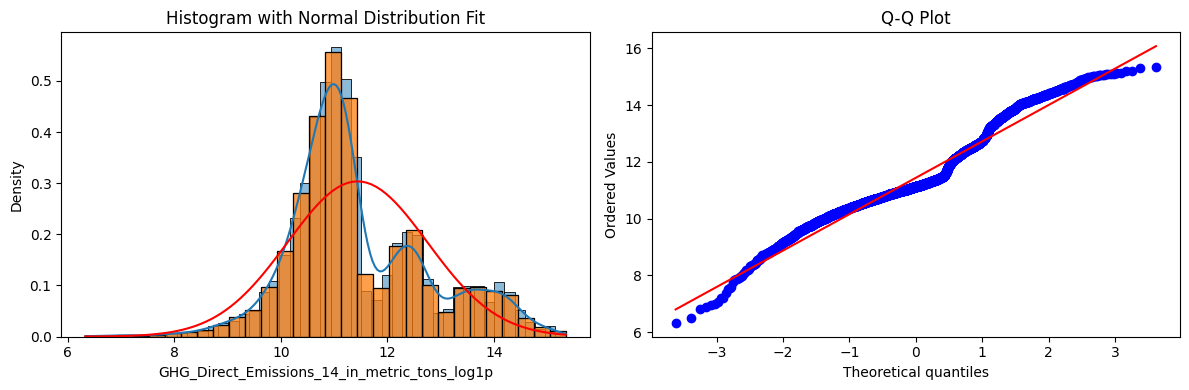

Skewness: 0.545884275422693
Kurtosis: 0.3515490436747801
isnull: 0


In [ ]:
train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'] = np.log1p(train_df['GHG_Direct_Emissions_14_in_metric_tons'])
normal_distribution_fit(train_df, 'GHG_Direct_Emissions_14_in_metric_tons_log1p')

In [ ]:
information_df(test_df)

(2508, 21)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,2508,"[4655, 4656, 4657, 4658, 4659, 4660, 4661, 466..."
FacilityName,object,0,2462,"[ROGER AOTSCHEGAROW, EPNG STATION 6543 LORDSBU..."
Latitude,float64,56,2437,"[38.03304, 32.31603, 41.2515, 44.95966, 32.818..."
Longitude,float64,56,2435,"[-97.97317, -108.6068, -78.74244, -93.19341, -..."
LocationAddress,object,113,2386,"[1910 SOUTH BROADACRES ROAD, nan, 3831 ROUTE 2..."
City,object,0,1647,"[HUTCHINSON, LORDSBURG, BROCKPORT, SAINT PAUL,..."
State,object,0,54,"[KS, NM, PA, MN, CA, MS, MT, AZ, IN, NY, IL, F..."
ZIP,object,0,2152,"[67501, 88045, 15823, 551141895, 92123, 38606,..."
County,object,45,865,"[RENO, HIDALGO, JEFFERSON, RAMSEY, SAN DIEGO, ..."
FIPScode,float64,45,1162,"[20155.0, 35023.0, 42065.0, 27123.0, 6073.0, 2..."


In [ ]:
def merge_train_test(df_train, df_test):
    if "is_train" not in df_test.columns.tolist():
        df_train["is_train"] = 100
        df_test["is_train"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["is_train"] != -100]
    df_test = df[df["is_train"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(train_df, test_df)

In [ ]:
# object型をカテゴリ型に変換する
for col in df.columns:
    if df[col].dtype == "object":  # object型の列を探す
        df[col] = df[col].astype("category")  # カテゴリ型に変換

# Locationにかかわる特徴量

In [ ]:
# import folium
# import matplotlib.cm as cm
# import matplotlib.colors as colors
# from IPython.display import display

# # 必要なデータを抽出し、新しいデータフレームを作成
# data = train_df[['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']].copy()

# # 緯度、経度、排出量のいずれかが欠損している行を削除
# data.dropna(subset=['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons'], inplace=True)

# # 各列のデータ型を float に変換
# for col in ['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']:
#     data[col] = data[col].astype(float)

# # 地図の中心をデータの緯度と経度の平均位置に設定
# map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
# m = folium.Map(location=map_center, zoom_start=5)

# # 排出量の最大値と最小値を取得
# max_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].max()
# min_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].min()

# # カラーマップを設定（排出量が少ない地点は黄色、多い地点は赤色で表示）
# colormap = cm.get_cmap('YlOrRd')
# normalize = colors.Normalize(vmin=min_emission, vmax=max_emission)

# # 各地点に対して、排出量に応じた色の円マーカーを作成し地図に追加
# for idx, row in data.iterrows():
#     # 排出量に基づいて色を設定
#     color = colors.rgb2hex(colormap(normalize(row['GHG_Direct_Emissions_14_in_metric_tons'])))

#     # 円マーカーを作成
#     folium.CircleMarker(
#         location=[row['Latitude'], row['Longitude']],  # 緯度・経度
#         radius=5,  # 円のサイズ
#         popup=f"Emissions: {row['GHG_Direct_Emissions_14_in_metric_tons']}",  # ポップアップに排出量を表示
#         color=color,  # 枠の色
#         fill=True,  # 円を塗りつぶす
#         fill_color=color  # 塗りつぶしの色
#     ).add_to(m)

# # 地図を表示（Jupyter Notebook 上で表示可能）
# display(m)


GHGが高い場所はまばら。地域差や業種に集約できる可能性はあり。
欠損値はそのままとして進める。

# industryにかかわる特徴量

'PrimaryNAICS'について

数字に応じたグループあり。
特に最初の2文字が業種を表す。

In [ ]:
naics_types      = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}

In [ ]:
df['PrimaryNAICS_1-2'] = df['PrimaryNAICS'].astype(str).str[:2].astype(int)
df['PrimaryNAICS_1-3'] = df['PrimaryNAICS'].astype(str).str[:3].astype(int)
df['PrimaryNAICS_1-4'] = df['PrimaryNAICS'].astype(str).str[:4].astype(int)
df['NAICS_Type'] = df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# 'na' などの変換できない値を NaN にしてから整数に変換
df['SecondPrimaryNAICS_1-2'] = pd.to_numeric(df['SecondPrimaryNAICS'].astype(str).str[:2], errors='coerce')
df['Sub_NAICS_Type'] = df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

df.head()

,Unnamed: 0,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,...,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons_log1p,is_train,PrimaryNAICS_1-2,PrimaryNAICS_1-3,PrimaryNAICS_1-4,NAICS_Type,SecondPrimaryNAICS_1-2,Sub_NAICS_Type
0,0,VISCOFAN USA INC,40.141389,-87.581111,915 N MICHIGAN AVE,DANVILLE,IL,61832,VERMILION,17183.0,...,45598.125851,52973.139946,10.877559,100,32,326,3261,Manufacturing,NaN,Manufacturing
1,1,"CORNWELL STATION - DOMINION TRANSMISSION, INC",38.475305,-81.278957,200 RIVER HAVEN ROAD,CLENDENIN,WV,25045-9304,KANAWHA,54039.0,...,76376.547318,55910.066617,10.931518,100,48,486,4862,Transportation and Warehousing,NaN,Transportation and Warehousing
2,2,WEST UNION COMPRESSOR STATION,39.299820,-80.857170,3041 LONG RUN RD.,GREENWOOD,WV,26415,RITCHIE,54085.0,...,NaN,55679.543214,10.927386,100,21,211,2111,"Mining, Quarrying, and Oil and Gas Extraction",NaN,"Mining, Quarrying, and Oil and Gas Extraction"
3,3,"DOUBLE ""C"" LIMITED",35.490363,-119.042957,10245 OILFIELD ROAD,BAKERSFIELD,CA,93308,KERN,6029.0,...,53799.011225,61411.902782,11.025375,100,22,221,2211,Utilities,NaN,Utilities
4,4,LAKESHORE PLANT,41.532802,-81.636448,6800 S MARGINAL RD,CLEVELAND,OH,441031047,CUYAHOGA,39035.0,...,17662.966241,43100.469774,10.671312,100,22,221,2211,Utilities,NaN,Utilities


数値の大きさに大きな意味はなさそうなので、categoryか新しい特徴量として使用するのが良いかもしれない。

In [ ]:
def create_features1(df):

    df['TRI_diff_11-10'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_diff_12-11'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_diff_13-12'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

    df['TRI_Growth_Rate_11'] = np.where(
        df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
        (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'],
        np.nan
    )

    df['TRI_Growth_Rate_12'] = np.where(
        df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
        (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'],
        np.nan
    )

    df['TRI_Growth_Rate_13'] = np.where(
        df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
        (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs'],
        np.nan
    )

    return df

df       = create_features1(df)
new_features1 = ['TRI_diff_11-10','TRI_diff_12-11','TRI_diff_13-12', 'TRI_Growth_Rate_11','TRI_Growth_Rate_12','TRI_Growth_Rate_13']

In [ ]:
train_distance = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/特徴量/train_distance_5nbrs_.csv')
test_distance = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/特徴量/test_distance_5nbrs_.csv')

In [ ]:
# def haversine(lat1, lon1, lat2, lon2):
#     # Convert latitude and longitude from degrees to radians
#     lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

#     # Haversine formula
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
#     a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
#     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

#     # Radius of Earth in kilometers (mean radius)
#     R = 6371.0

#     # Calculate the distance
#     distance = R * c
#     return distance

# def calculate_distance(lat1, lon1, lat2, lon2):
#     return haversine(lat1, lon1, lat2, lon2)

# def get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=5, train_point=False):
#     # Extract the required columns once to NumPy arrays
#     latitudes = train_df['Latitude'].values
#     longitudes = train_df['Longitude'].values
#     ghg_emissions = train_df['GHG_Direct_Emissions_14_in_metric_tons'].values
#     econ_sectors = train_df['NAICS_Type'].values

#     # Filter NaN emissions directly
#     valid_indices = ~np.isnan(ghg_emissions)

#     latitudes = latitudes[valid_indices]
#     longitudes = longitudes[valid_indices]
#     ghg_emissions = ghg_emissions[valid_indices]
#     econ_sectors = econ_sectors[valid_indices]

#     # Parallelize distance calculation using ThreadPoolExecutor
#     with ThreadPoolExecutor() as executor:
#         distances = list(executor.map(calculate_distance,
#                                      [lat1]*len(latitudes),
#                                      [lon1]*len(longitudes),
#                                      latitudes,
#                                      longitudes))

#     # Combine the results into a DataFrame
#     near_df = pd.DataFrame({
#         'Distance': distances,
#         'GHG_emission_14': ghg_emissions,
#         'Economic_Sector': econ_sectors
#     })


#     if train_point:
#         near_df.sort_values(by='Distance', inplace=True)
#         near_df = near_df.dropna()
#         near_df = near_df.iloc[1:].reset_index(drop=True)
#     else:
#         # Sort distances by 'Distance'
#         near_df.sort_values(by='Distance', inplace=True)
#         near_df = near_df.dropna()

#     # Filter by economic sector
#     nearest_locations_econ_sector = near_df[near_df['Economic_Sector'] == econ_sector_ref]

#     # Get the top N nearest for both economic sector and overall
#     sub_near_econ = nearest_locations_econ_sector.head(neighbours)
#     sub_nearest_locations = near_df.head(neighbours)

#     # Compute weighted averages
#     econ_weighted_average = (sub_near_econ['GHG_emission_14'] / np.where(sub_near_econ['Distance'] == 0, 1, sub_near_econ['Distance']) ).sum()
#     near_weighted_average = (sub_nearest_locations['GHG_emission_14'] / np.where(sub_nearest_locations['Distance']==0,1,sub_nearest_locations['Distance'])).sum()

#     # Compute regular averages
#     econ_average = sub_near_econ['GHG_emission_14'].mean()
#     near_average = sub_nearest_locations['GHG_emission_14'].mean()

#     return [econ_weighted_average, econ_average, near_weighted_average, near_average]

In [ ]:
# neighbours = 5

# file_path = f"test_distance_{neighbours}nbrs.csv"
# if os.path.exists(file_path):
#     print(f"{file_path} exists. ")
#     test_distance = pd.read_csv(f"test_distance_{neighbours}nbrs.csv")
# else:
#     output = []
#     for index in tqdm(range(test_df.shape[0])):

#         lat1 = test_df.iloc[index]['Latitude']
#         lon1 = test_df.iloc[index]['Longitude']
#         econ_sector_ref = test_df.iloc[index]['NAICS_Type']
#         x = get_nearest_distance(lat1,lon1,econ_sector_ref,neighbours=neighbours,train_point=False)
#         output.append(x)
#     test_distance = pd.DataFrame(output,columns = ['Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average'])
#     test_distance.to_csv(f'test_distance_{neighbours}nbrs.csv',index=False)

# file_path = f"train_distance_{neighbours}nbrs.csv"
# if os.path.exists(file_path):
#     print(f"{file_path} exists. ")
#     train_distance = pd.read_csv(f'train_distance_{neighbours}nbrs.csv')
# else:
#     output = []
#     for index in tqdm(range(train_df.shape[0])):
#         lat1 = train_df.iloc[index]['Latitude']
#         lon1 = train_df.iloc[index]['Longitude']
#         econ_sector_ref = train_df.iloc[index]['NAICS_Type']
#         x = get_nearest_distance(lat1,lon1,econ_sector_ref,neighbours=neighbours, train_point=True)
#         output.append(x)
#     train_distance = pd.DataFrame(output,columns = ['Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average'])
#     train_distance.to_csv(f'train_distance_{neighbours}nbrs.csv',index=False)

train_df, test_df = split_train_test(df)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df = pd.concat((train_df,train_distance),axis=1)

# インデックスをリセットしてから結合
test_df = test_df.reset_index(drop=True)
test_distance = test_distance.reset_index(drop=True)
test_df = pd.concat((test_df, test_distance), axis=1)

# train_df['Economy_Sector_Weighted_Avg'] = train_df['Economy_Sector_Weighted_Avg'].fillna(0)
# train_df['Economic_Sector_Average'] = train_df['Economic_Sector_Average'].fillna(0)

In [ ]:
features = [
                        'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
                    'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs','PrimaryNAICS',
                    'GHG_Direct_Emissions_10_in_metric_tons', 'GHG_Direct_Emissions_11_in_metric_tons',
                    'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons',
                        'Latitude','Longitude',
                        'TRI_diff_11-10','TRI_diff_12-11','TRI_diff_13-12', 'TRI_Growth_Rate_11','TRI_Growth_Rate_12','TRI_Growth_Rate_13',
                        'NAICS_Type',
]

In [ ]:
train = train_df[features]
target = train_df['GHG_Direct_Emissions_14_in_metric_tons']
test = test_df[features]

In [ ]:
# pip install optuna

In [ ]:
# import optuna
# from sklearn.metrics import root_mean_squared_log_error
# from xgboost import XGBRegressor
# from sklearn.model_selection import KFold
# import numpy as np
# import gc

# N_SPLITS = 15
# SEED_SKF = 42
# np.random.seed(42)

# kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

# def objective(trial, train, target):
#     # Optunaで探索するパラメータ
#     xgb_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 300, 700),
#         "max_depth": 4,
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.01),
#         "subsample": trial.suggest_float("subsample", 0.6, 0.8),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.8),
#         "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.01, 10.0),
#         "reg_lambda": trial.suggest_loguniform("reg_lambda", 1.0, 10.0),
#         "random_state": 42,
#         'enable_categorical': True,
#     }

#     oof_predictions = np.zeros(len(train))
#     fold_rmsle = []
#     train_predictions = np.zeros(len(train))

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         model = XGBRegressor(**xgb_params)
#         _ = model.fit(X_train, np.log1p(y_train))

#         valid_preds = np.expm1(model.predict(X_valid))
#         train_preds = np.expm1(model.predict(X_train))

#         rmsle_valid = root_mean_squared_log_error(y_valid, valid_preds)
#         rmsle_train = root_mean_squared_log_error(y_train, train_preds)

#         oof_predictions[valid_index] = valid_preds
#         train_predictions[train_index] = train_preds

#         print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

#     RMSLE = root_mean_squared_log_error(target, oof_predictions)
#     tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
#     print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")
#     print("-" * 50)



#     return RMSLE


# # Optunaでのハイパーパラメータ最適化
# study = optuna.create_study(direction="minimize")
# study.optimize(lambda trial: objective(trial, train, target), n_trials=50)

# # 最良のパラメータをリストに格納
# params_list = [trial.params for trial in study.trials]

# # 選択した範囲のRMSLEスコアを格納するリスト
# valid_params_with_rmsle = []


In [ ]:
# import optuna
# from sklearn.metrics import mean_squared_log_error
# from lightgbm import LGBMRegressor
# import lightgbm as lgb
# from sklearn.model_selection import KFold
# import numpy as np
# import gc

# N_SPLITS = 15
# SEED_SKF = 42
# np.random.seed(42)

# kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

# def objective(trial, train, target, num_folds=5):
#     # Optunaで探索するパラメータ
#     lgbm_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 10, 100),
#         "max_depth": 3,
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.05, 0.5),
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.01, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1.0, 10.0),
#         "random_state": 42,
#         'objective': 'regression',
#         'metric': 'rmse',
#         'boosting_type': 'gbdt',
#         'verbose': -1,
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 30, 50),
#         "max_bin": trial.suggest_int("max_bin", 150, 200),
#     }

#     oof_predictions = np.zeros(len(train))
#     fold_rmsle = []
#     train_predictions = np.zeros(len(train))

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         model = LGBMRegressor(**lgbm_params)
#         model.fit(
#             X_train,
#             np.log1p(y_train),
#             eval_set=[(X_valid, y_valid)],
#             callbacks=[
#                 lgb.early_stopping(stopping_rounds=50, verbose=False),
#                 lgb.log_evaluation(0)],
#         )
#         valid_preds = np.expm1(model.predict(X_valid))
#         train_preds = np.expm1(model.predict(X_train))

#         rmsle_valid = mean_squared_log_error(y_valid, valid_preds, squared=False)
#         rmsle_train = mean_squared_log_error(y_train, train_preds, squared=False)

#         oof_predictions[valid_index] = valid_preds
#         train_predictions[train_index] = train_preds

#         print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

#     RMSLE = root_mean_squared_log_error(target, oof_predictions)
#     tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
#     print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")
#     print("-" * 50)

#     return RMSLE

# # Optunaでのハイパーパラメータ最適化
# study = optuna.create_study(direction="minimize")
# study.optimize(lambda trial: objective(trial, train, target), n_trials=50)

# # 最良のパラメータをリストに格納
# params_list = [trial.params for trial in study.trials]

# # 選択した範囲のRMSLEスコアを格納するリスト
# valid_params_with_rmsle = []


In [ ]:

# import optuna
# from sklearn.metrics import mean_squared_log_error
# from catboost import CatBoostRegressor
# from sklearn.model_selection import KFold
# import numpy as np
# import gc

# N_SPLITS = 15
# SEED_SKF = 42
# np.random.seed(42)

# kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

# def objective(trial, train, target, num_folds=5):
#     # Optunaで探索するパラメータ
#     catboost_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#         "depth": trial.suggest_int("depth", 3, 7),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),
#         "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1.0, 50.0),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1),
#         'border_count': trial.suggest_int('border_count', 100, 500),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf",10, 100),
#         "random_state": 42,
#         'objective': 'RMSE',
#         "eval_metric": "RMSE",
#         'loss_function': 'RMSE',
#         "subsample": 1,
#         "verbose": 0
#     }

#     oof_predictions = np.zeros(len(train))
#     fold_rmsle = []

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         categorical_features = ['NAICS_Type']

#         for col in categorical_features:
#           X_train[col] = X_train[col].astype(str).fillna("missing")
#           X_valid[col] = X_valid[col].astype(str).fillna("missing")

#         model = CatBoostRegressor(**catboost_params)
#         model.fit(
#         X_train,
#         y_train,
#         eval_set=(X_valid, y_valid),
#         cat_features=categorical_features,
#         early_stopping_rounds=50,
#     )

#         valid_preds = np.maximum(0, model.predict(X_valid))
#         train_preds = np.maximum(0, model.predict(X_train))

#         rmsle_valid = mean_squared_log_error(y_valid, valid_preds, squared=False)
#         rmsle_train = mean_squared_log_error(y_train, train_preds, squared=False)

#         oof_predictions[valid_index] = valid_preds

#         print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

#     RMSLE = mean_squared_log_error(target, oof_predictions, squared=False)
#     print(f"[CV] Valid RMSLE: {RMSLE:.5f}")
#     print("-" * 50)

#     return RMSLE

# # Optunaでのハイパーパラメータ最適化
# study = optuna.create_study(direction="minimize")
# study.optimize(lambda trial: objective(trial, train, target), n_trials=50)

# # 最良のパラメータをリストに格納
# params_list = [trial.params for trial in study.trials]

# # 選択した範囲のRMSLEスコアを格納するリスト
# valid_params_with_rmsle = []


In [ ]:
from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import gc
import numpy as np
import lightgbm as lgb

gc.collect()

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_predictions = np.zeros(len(train))
    fold_train_rmsle = []

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"------------------------------ fold {fold} ------------------------------")

        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model_dict = {}
        loss_dict = {}
        valid_preds_dict = {}
        train_preds_dict = {}
        rmsle_dict = {}

        # モデル1
        params1 = {
            'n_estimators': 595, 'learning_rate': 0.007624351393824647, 'subsample': 0.700276785552184, 'colsample_bytree': 0.7339579594424095, 'reg_alpha': 0.29107185146455633, 'reg_lambda': 2.641123852967307,
            "max_depth": 4,
            "random_state": 42,
            'enable_categorical': True,
        }
        model1 = XGBRegressor(**params1)

        # モデル1の学習と予測
        _ = model1.fit(X_train, np.log1p(y_train))
        valid_preds1 = np.expm1(model1.predict(X_valid))
        train_preds1 = np.expm1(model1.predict(X_train))
        rmsle1 = root_mean_squared_log_error(y_valid, valid_preds1)
        tr_rmsle1 = root_mean_squared_log_error(y_train, train_preds1)
        print(f"Fold {fold} model1 tr:{tr_rmsle1:.5f} va:{rmsle1:.5f}")

        loss_dict["model1"] = rmsle1
        model_dict['model1'] = model1
        valid_preds_dict['model1'] = valid_preds1
        train_preds_dict['model1'] = train_preds1
        rmsle_dict['model1'] = rmsle1

        # モデル2
        params2 = {
            'n_estimators': 496, 'learning_rate': 0.009252715170077622, 'subsample': 0.7167164015002879, 'colsample_bytree': 0.6412076957770685, 'reg_alpha': 0.3696375956764805, 'reg_lambda': 2.467273343804692,
            "max_depth": 4,
            "random_state": 42,
            'enable_categorical': True,
        }
        model2 = XGBRegressor(**params2)

        # モデル2の学習と予測
        _ = model2.fit(X_train, np.log1p(y_train))
        valid_preds2 = np.expm1(model2.predict(X_valid))
        train_preds2 = np.expm1(model2.predict(X_train))
        rmsle2 = root_mean_squared_log_error(y_valid, valid_preds2)
        tr_rmsle2 = root_mean_squared_log_error(y_train, train_preds2)
        print(f"Fold {fold} model2 tr:{tr_rmsle2:.5f} va:{rmsle2:.5f}")

        loss_dict["model2"] = rmsle2
        model_dict['model2'] = model2
        valid_preds_dict['model2'] = valid_preds2
        train_preds_dict['model2'] = train_preds2
        rmsle_dict['model2'] = rmsle2

        # モデル3
        params3 = {
            'n_estimators': 86, 'learning_rate': 0.05997247493517289, 'lambda_l1': 0.039698269771453513, 'lambda_l2': 1.3209099884337212, 'min_data_in_leaf': 35, 'max_bin': 169,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,

        }
        model3 = LGBMRegressor(**params3)

        # モデル3の学習と予測
        model3.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds3 = np.expm1(model3.predict(X_valid))
        train_preds3 = np.expm1(model3.predict(X_train))
        rmsle3 = root_mean_squared_log_error(y_valid, valid_preds3)
        tr_rmsle3 = root_mean_squared_log_error(y_train, train_preds3)
        print(f"Fold {fold} model3 tr:{tr_rmsle3:.5f} va:{rmsle3:.5f}")

        loss_dict["model3"] = rmsle3
        model_dict['model3'] = model3
        valid_preds_dict['model3'] = valid_preds3
        train_preds_dict['model3'] = train_preds3
        rmsle_dict['model3'] = rmsle3

        # モデル4
        params4 = {
            'n_estimators': 70, 'learning_rate': 0.07163113404511691, 'lambda_l1': 0.018462551672613223, 'lambda_l2': 1.6493096737478277, 'min_data_in_leaf': 34, 'max_bin': 170,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,
        }
        model4 = LGBMRegressor(**params4)

        # モデル4の学習と予測
        model4.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds4 = np.expm1(model4.predict(X_valid))
        train_preds4 = np.expm1(model4.predict(X_train))
        rmsle4 = root_mean_squared_log_error(y_valid, valid_preds4)
        tr_rmsle4 = root_mean_squared_log_error(y_train, train_preds4)
        print(f"Fold {fold} model4 tr:{tr_rmsle4:.5f} va:{rmsle4:.5f}")

        loss_dict["model4"] = rmsle4
        model_dict['model4'] = model4
        valid_preds_dict['model4'] = valid_preds4
        train_preds_dict['model4'] = train_preds4
        rmsle_dict['model4'] = rmsle4


        # 各モデルの予測の平均値を算出して評価
        valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
        train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

        rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

        rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        min_loss_model = min(loss_dict, key=loss_dict.get)
        model = model_dict[min_loss_model]
        valid_preds_best_model = np.expm1(model.predict(X_valid))
        rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
        train_preds_best_model = np.expm1(model.predict(X_train))
        tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

        print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

        oof_predictions[valid_index] = valid_preds_mean
        train_predictions[train_index] = train_preds_mean

        # テストデータの予測
        test_preds = model.predict(test)
        test_predictions += test_preds / kf.n_splits

        gc.collect()

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print()
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

    return oof_predictions, train_predictions, np.expm1(test_predictions)

oof_predictions, train_predictions, test_predictions = get_models_trained(train, test, target, 15)

------------------------------ fold 0 ------------------------------
Fold 0 model1 tr:0.70012 va:0.67748
Fold 0 model2 tr:0.70112 va:0.67819
Fold 0 model3 tr:0.72742 va:0.67949
Fold 0 model4 tr:0.72750 va:0.68055
Fold 0 Ave    tr:0.71288 va:0.67811
------------------------------ fold 1 ------------------------------
Fold 1 model1 tr:0.69307 va:0.77721
Fold 1 model2 tr:0.69464 va:0.77829
Fold 1 model3 tr:0.72051 va:0.77796
Fold 1 model4 tr:0.72103 va:0.77987
Fold 1 Ave    tr:0.70620 va:0.77711
------------------------------ fold 2 ------------------------------
Fold 2 model1 tr:0.69485 va:0.75916
Fold 2 model2 tr:0.69555 va:0.75827
Fold 2 model3 tr:0.72296 va:0.76148
Fold 2 model4 tr:0.72352 va:0.76049
Fold 2 Ave    tr:0.70797 va:0.75849
------------------------------ fold 3 ------------------------------
Fold 3 model1 tr:0.69938 va:0.68740
Fold 3 model2 tr:0.69981 va:0.68591
Fold 3 model3 tr:0.72738 va:0.68358
Fold 3 model4 tr:0.72730 va:0.68320
Fold 3 Ave    tr:0.71228 va:0.68386
----

------------------------------ fold 0 ------------------------------
Fold 0 model1 tr:0.70012 va:0.67748
------------------------------ fold 1 ------------------------------
Fold 1 model1 tr:0.69307 va:0.77721
------------------------------ fold 2 ------------------------------
Fold 2 model1 tr:0.69485 va:0.75916
------------------------------ fold 3 ------------------------------
Fold 3 model1 tr:0.69938 va:0.68740
------------------------------ fold 4 ------------------------------
Fold 4 model1 tr:0.69495 va:0.75844
------------------------------ fold 5 ------------------------------
Fold 5 model1 tr:0.69456 va:0.77757
------------------------------ fold 6 ------------------------------
Fold 6 model1 tr:0.69656 va:0.73526
------------------------------ fold 7 ------------------------------
Fold 7 model1 tr:0.69479 va:0.76275
------------------------------ fold 8 ------------------------------
Fold 8 model1 tr:0.69060 va:0.82788
------------------------------ fold 9 -----------------

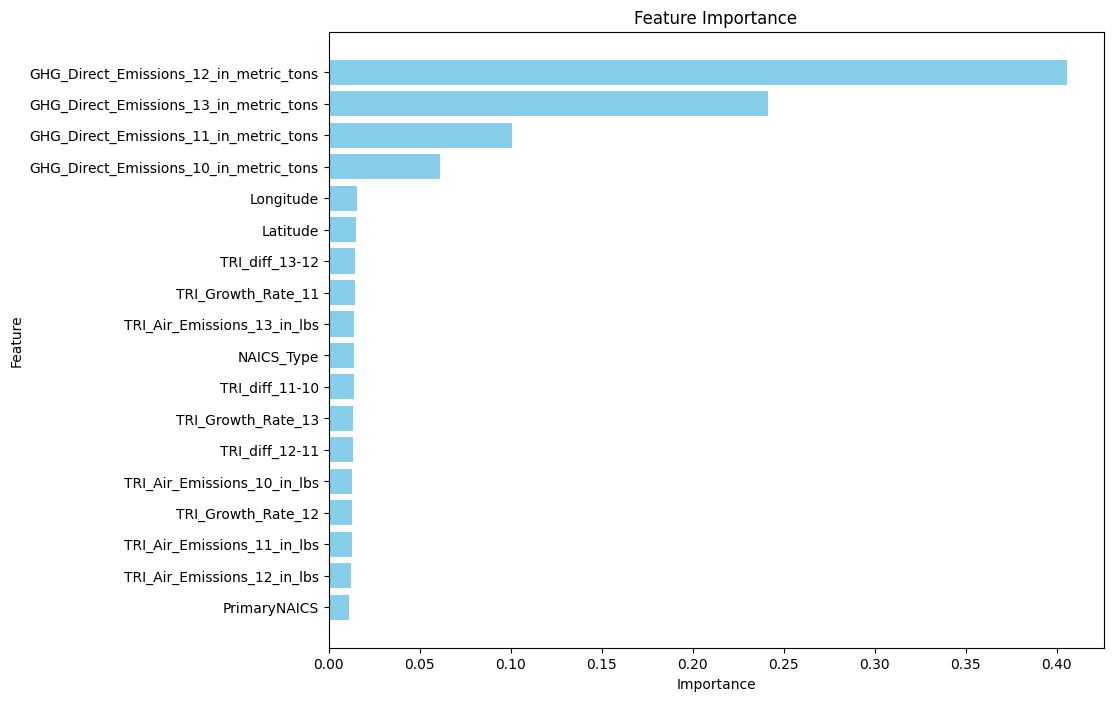

In [ ]:
from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import gc
import numpy as np
import lightgbm as lgb

gc.collect()

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_predictions = np.zeros(len(train))
    fold_train_rmsle = []
    feature_importance_df = pd.DataFrame()

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"------------------------------ fold {fold} ------------------------------")

        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model_dict = {}
        loss_dict = {}
        valid_preds_dict = {}
        train_preds_dict = {}
        rmsle_dict = {}

        # モデル1
        params1 = {
            'n_estimators': 595, 'learning_rate': 0.007624351393824647, 'subsample': 0.700276785552184, 'colsample_bytree': 0.7339579594424095, 'reg_alpha': 0.29107185146455633, 'reg_lambda': 2.641123852967307,
            "max_depth": 4,
            "random_state": 42,
            'enable_categorical': True,
        }
        model1 = XGBRegressor(**params1)

        # モデル1の学習と予測
        _ = model1.fit(X_train, np.log1p(y_train))
        valid_preds1 = np.expm1(model1.predict(X_valid))
        train_preds1 = np.expm1(model1.predict(X_train))
        rmsle1 = root_mean_squared_log_error(y_valid, valid_preds1)
        tr_rmsle1 = root_mean_squared_log_error(y_train, train_preds1)
        print(f"Fold {fold} model1 tr:{tr_rmsle1:.5f} va:{rmsle1:.5f}")

        loss_dict["model1"] = rmsle1
        model_dict['model1'] = model1
        valid_preds_dict['model1'] = valid_preds1
        train_preds_dict['model1'] = train_preds1
        rmsle_dict['model1'] = rmsle1

        # 取得した特徵重要度をデータフレームに追加
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = train.columns
        fold_importance_df["importance"] = model1.feature_importances_
        fold_importance_df["fold"] = fold
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


        # 各モデルの予測の平均値を算出して評価
        valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
        train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

        rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

        rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        min_loss_model = min(loss_dict, key=loss_dict.get)
        model = model_dict[min_loss_model]
        valid_preds_best_model = np.expm1(model.predict(X_valid))
        rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
        train_preds_best_model = np.expm1(model.predict(X_train))
        tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

        # print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

        oof_predictions[valid_index] = valid_preds_mean
        train_predictions[train_index] = train_preds_mean

        # テストデータの予測
        test_preds = model.predict(test)
        test_predictions += test_preds / kf.n_splits

        gc.collect()

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print()
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

    # 特徵重要度の表示
    feature_importance_df = feature_importance_df.groupby("feature")["importance"].mean().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df["feature"], feature_importance_df["importance"], color='skyblue')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

    return oof_predictions, train_predictions, np.expm1(test_predictions)

oof_predictions, train_predictions, test_predictions = get_models_trained(train, test, target, 15)

------------------------------ fold 0 ------------------------------
Fold 0 model2 tr:0.70112 va:0.67819
------------------------------ fold 1 ------------------------------
Fold 1 model2 tr:0.69464 va:0.77829
------------------------------ fold 2 ------------------------------
Fold 2 model2 tr:0.69555 va:0.75827
------------------------------ fold 3 ------------------------------
Fold 3 model2 tr:0.69981 va:0.68591
------------------------------ fold 4 ------------------------------
Fold 4 model2 tr:0.69583 va:0.75971
------------------------------ fold 5 ------------------------------
Fold 5 model2 tr:0.69588 va:0.77719
------------------------------ fold 6 ------------------------------
Fold 6 model2 tr:0.69728 va:0.73485
------------------------------ fold 7 ------------------------------
Fold 7 model2 tr:0.69602 va:0.76374
------------------------------ fold 8 ------------------------------
Fold 8 model2 tr:0.69136 va:0.82740
------------------------------ fold 9 -----------------

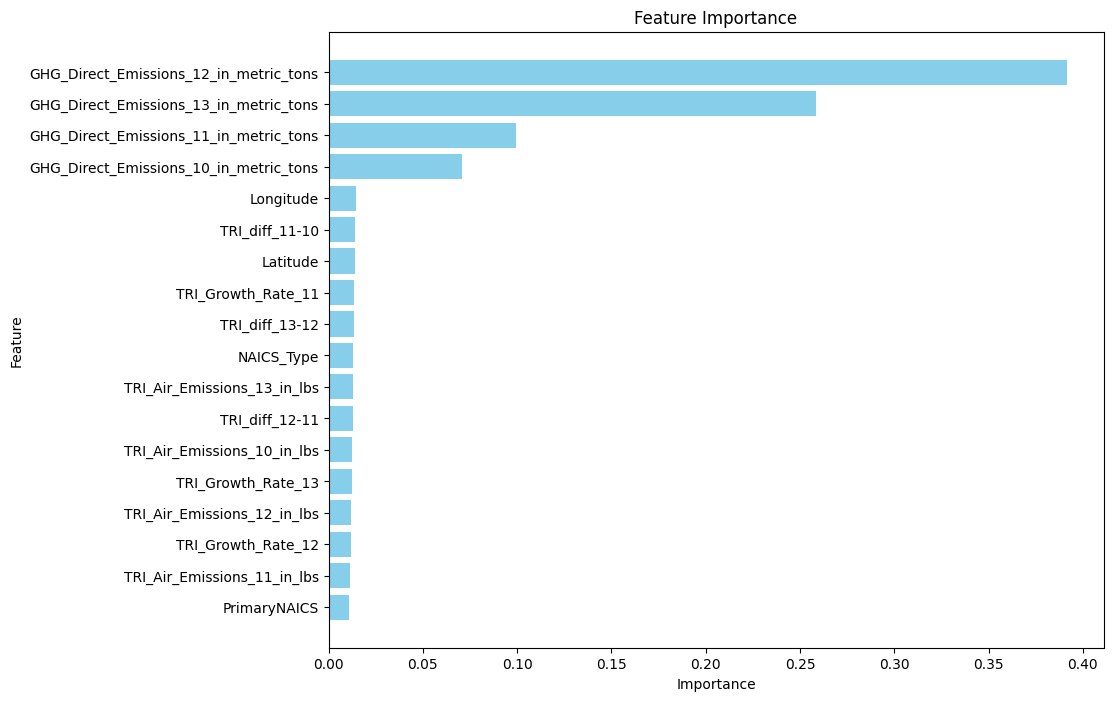

In [ ]:
from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import gc
import numpy as np
import lightgbm as lgb

gc.collect()

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_predictions = np.zeros(len(train))
    fold_train_rmsle = []
    feature_importance_df = pd.DataFrame()
    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"------------------------------ fold {fold} ------------------------------")

        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model_dict = {}
        loss_dict = {}
        valid_preds_dict = {}
        train_preds_dict = {}
        rmsle_dict = {}

        params2 = {
            'n_estimators': 496, 'learning_rate': 0.009252715170077622, 'subsample': 0.7167164015002879, 'colsample_bytree': 0.6412076957770685, 'reg_alpha': 0.3696375956764805, 'reg_lambda': 2.467273343804692,
            "max_depth": 4,
            "random_state": 42,
            'enable_categorical': True,
        }
        model2 = XGBRegressor(**params2)

        # モデル2の学習と予測
        _ = model2.fit(X_train, np.log1p(y_train))
        valid_preds2 = np.expm1(model2.predict(X_valid))
        train_preds2 = np.expm1(model2.predict(X_train))
        rmsle2 = root_mean_squared_log_error(y_valid, valid_preds2)
        tr_rmsle2 = root_mean_squared_log_error(y_train, train_preds2)
        print(f"Fold {fold} model2 tr:{tr_rmsle2:.5f} va:{rmsle2:.5f}")

        loss_dict["model2"] = rmsle2
        model_dict['model2'] = model2
        valid_preds_dict['model2'] = valid_preds2
        train_preds_dict['model2'] = train_preds2
        rmsle_dict['model2'] = rmsle2

        # 取得した特徵重要度をデータフレームに追加
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = train.columns
        fold_importance_df["importance"] = model2.feature_importances_
        fold_importance_df["fold"] = fold
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


        # 各モデルの予測の平均値を算出して評価
        valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
        train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

        rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

        rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        min_loss_model = min(loss_dict, key=loss_dict.get)
        model = model_dict[min_loss_model]
        valid_preds_best_model = np.expm1(model.predict(X_valid))
        rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
        train_preds_best_model = np.expm1(model.predict(X_train))
        tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

        # print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

        oof_predictions[valid_index] = valid_preds_mean
        train_predictions[train_index] = train_preds_mean

        # テストデータの予測
        test_preds = model.predict(test)
        test_predictions += test_preds / kf.n_splits

        gc.collect()

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print()
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

    # 特徵重要度の表示
    feature_importance_df = feature_importance_df.groupby("feature")["importance"].mean().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df["feature"], feature_importance_df["importance"], color='skyblue')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

    return oof_predictions, train_predictions, np.expm1(test_predictions)

oof_predictions, train_predictions, test_predictions = get_models_trained(train, test, target, 15)

------------------------------ fold 0 ------------------------------
Fold 0 model3 tr:0.72742 va:0.67949
------------------------------ fold 1 ------------------------------
Fold 1 model3 tr:0.72051 va:0.77796
------------------------------ fold 2 ------------------------------
Fold 2 model3 tr:0.72296 va:0.76148
------------------------------ fold 3 ------------------------------
Fold 3 model3 tr:0.72738 va:0.68358
------------------------------ fold 4 ------------------------------
Fold 4 model3 tr:0.72261 va:0.76478
------------------------------ fold 5 ------------------------------
Fold 5 model3 tr:0.72117 va:0.78060
------------------------------ fold 6 ------------------------------
Fold 6 model3 tr:0.72352 va:0.73912
------------------------------ fold 7 ------------------------------
Fold 7 model3 tr:0.72176 va:0.76786
------------------------------ fold 8 ------------------------------
Fold 8 model3 tr:0.71736 va:0.82993
------------------------------ fold 9 -----------------

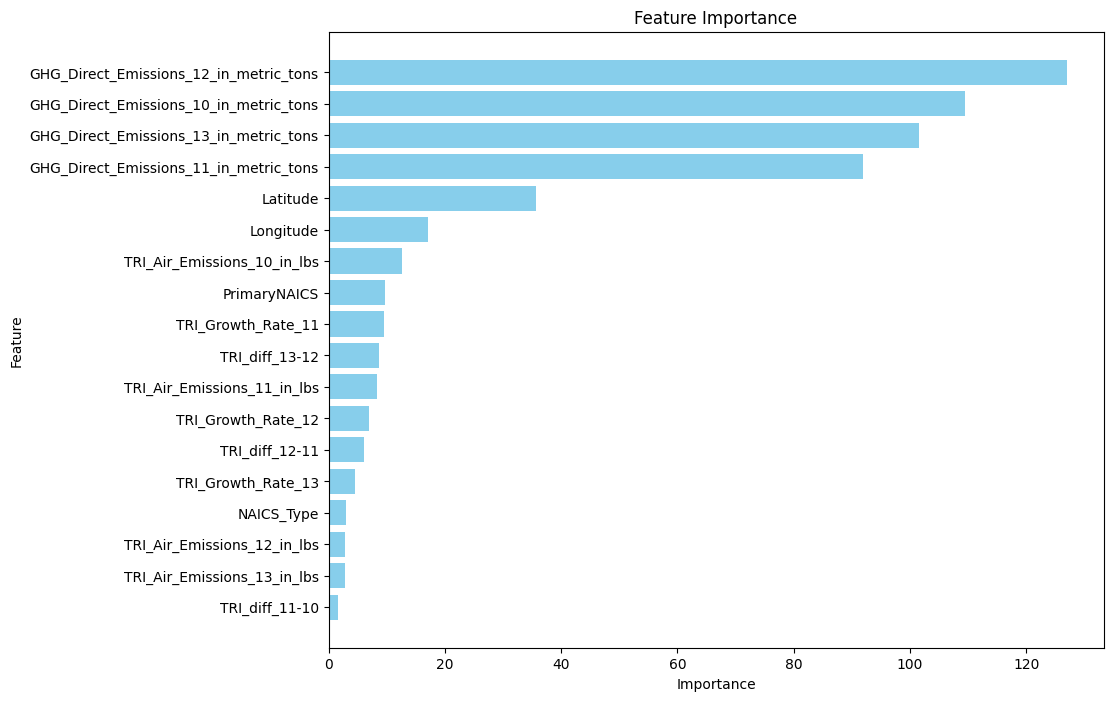

In [ ]:
from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import gc
import numpy as np
import lightgbm as lgb

gc.collect()

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_predictions = np.zeros(len(train))
    fold_train_rmsle = []
    feature_importance_df = pd.DataFrame()
    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"------------------------------ fold {fold} ------------------------------")

        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model_dict = {}
        loss_dict = {}
        valid_preds_dict = {}
        train_preds_dict = {}
        rmsle_dict = {}

        # モデル3
        params3 = {
            'n_estimators': 86, 'learning_rate': 0.05997247493517289, 'lambda_l1': 0.039698269771453513, 'lambda_l2': 1.3209099884337212, 'min_data_in_leaf': 35, 'max_bin': 169,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,

        }
        model3 = LGBMRegressor(**params3)

        # モデル3の学習と予測
        model3.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds3 = np.expm1(model3.predict(X_valid))
        train_preds3 = np.expm1(model3.predict(X_train))
        rmsle3 = root_mean_squared_log_error(y_valid, valid_preds3)
        tr_rmsle3 = root_mean_squared_log_error(y_train, train_preds3)
        print(f"Fold {fold} model3 tr:{tr_rmsle3:.5f} va:{rmsle3:.5f}")

        loss_dict["model3"] = rmsle3
        model_dict['model3'] = model3
        valid_preds_dict['model3'] = valid_preds3
        train_preds_dict['model3'] = train_preds3
        rmsle_dict['model3'] = rmsle3

        # 取得した特徵重要度をデータフレームに追加
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = train.columns
        fold_importance_df["importance"] = model3.feature_importances_
        fold_importance_df["fold"] = fold
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


        # 各モデルの予測の平均値を算出して評価
        valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
        train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

        rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

        rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        min_loss_model = min(loss_dict, key=loss_dict.get)
        model = model_dict[min_loss_model]
        valid_preds_best_model = np.expm1(model.predict(X_valid))
        rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
        train_preds_best_model = np.expm1(model.predict(X_train))
        tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

        # print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

        oof_predictions[valid_index] = valid_preds_mean
        train_predictions[train_index] = train_preds_mean

        # テストデータの予測
        test_preds = model.predict(test)
        test_predictions += test_preds / kf.n_splits

        gc.collect()

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print()
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

    # 特徵重要度の表示
    feature_importance_df = feature_importance_df.groupby("feature")["importance"].mean().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df["feature"], feature_importance_df["importance"], color='skyblue')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

    return oof_predictions, train_predictions, np.expm1(test_predictions)

oof_predictions, train_predictions, test_predictions = get_models_trained(train, test, target, 15)

------------------------------ fold 0 ------------------------------
Fold 0 model4 tr:0.72750 va:0.68055
------------------------------ fold 1 ------------------------------
Fold 1 model4 tr:0.72103 va:0.77987
------------------------------ fold 2 ------------------------------
Fold 2 model4 tr:0.72352 va:0.76049
------------------------------ fold 3 ------------------------------
Fold 3 model4 tr:0.72730 va:0.68320
------------------------------ fold 4 ------------------------------
Fold 4 model4 tr:0.72283 va:0.76182
------------------------------ fold 5 ------------------------------
Fold 5 model4 tr:0.72176 va:0.78217
------------------------------ fold 6 ------------------------------
Fold 6 model4 tr:0.72526 va:0.73695
------------------------------ fold 7 ------------------------------
Fold 7 model4 tr:0.72242 va:0.77155
------------------------------ fold 8 ------------------------------
Fold 8 model4 tr:0.71778 va:0.82841
------------------------------ fold 9 -----------------

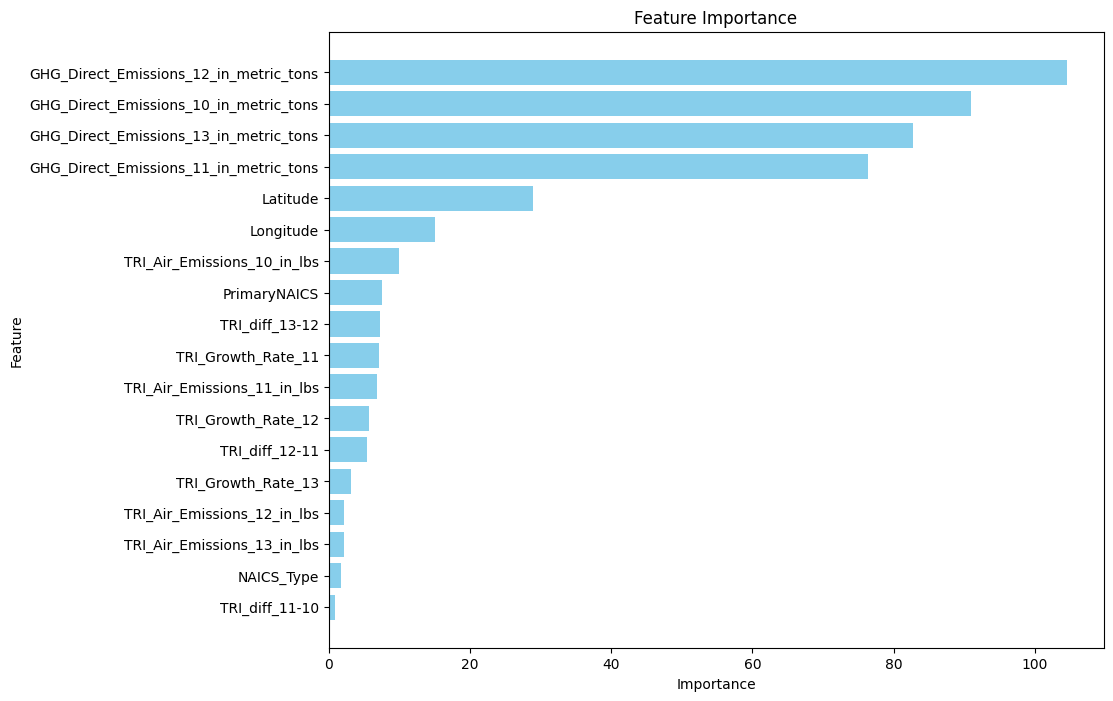

In [ ]:
from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import gc
import numpy as np
import lightgbm as lgb

gc.collect()

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_predictions = np.zeros(len(train))
    fold_train_rmsle = []
    feature_importance_df = pd.DataFrame()
    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"------------------------------ fold {fold} ------------------------------")

        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model_dict = {}
        loss_dict = {}
        valid_preds_dict = {}
        train_preds_dict = {}
        rmsle_dict = {}

        # モデル4
        params4 = {
            'n_estimators': 70, 'learning_rate': 0.07163113404511691, 'lambda_l1': 0.018462551672613223, 'lambda_l2': 1.6493096737478277, 'min_data_in_leaf': 34, 'max_bin': 170,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,
        }
        model4 = LGBMRegressor(**params4)

        # モデル4の学習と予測
        model4.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds4 = np.expm1(model4.predict(X_valid))
        train_preds4 = np.expm1(model4.predict(X_train))
        rmsle4 = root_mean_squared_log_error(y_valid, valid_preds4)
        tr_rmsle4 = root_mean_squared_log_error(y_train, train_preds4)
        print(f"Fold {fold} model4 tr:{tr_rmsle4:.5f} va:{rmsle4:.5f}")

        loss_dict["model4"] = rmsle4
        model_dict['model4'] = model4
        valid_preds_dict['model4'] = valid_preds4
        train_preds_dict['model4'] = train_preds4
        rmsle_dict['model4'] = rmsle4

        # 取得した特徵重要度をデータフレームに追加
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = train.columns
        fold_importance_df["importance"] = model4.feature_importances_
        fold_importance_df["fold"] = fold
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


        # 各モデルの予測の平均値を算出して評価
        valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
        train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

        rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

        rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        min_loss_model = min(loss_dict, key=loss_dict.get)
        model = model_dict[min_loss_model]
        valid_preds_best_model = np.expm1(model.predict(X_valid))
        rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
        train_preds_best_model = np.expm1(model.predict(X_train))
        tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

        # print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

        oof_predictions[valid_index] = valid_preds_mean
        train_predictions[train_index] = train_preds_mean

        # テストデータの予測
        test_preds = model.predict(test)
        test_predictions += test_preds / kf.n_splits

        gc.collect()

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print()
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

    # 特徵重要度の表示
    feature_importance_df = feature_importance_df.groupby("feature")["importance"].mean().sort_values(ascending=False).reset_index()
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df["feature"], feature_importance_df["importance"], color='skyblue')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

    return oof_predictions, train_predictions, np.expm1(test_predictions)

oof_predictions, train_predictions, test_predictions = get_models_trained(train, test, target, 15)

# 提出データ

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/sample_submission.csv', header=None)
submit[1] = test_predictions
submit.to_csv('submit_ghg27.csv', header=None, index=False)

# 投稿ファイルの中身を確認
submit.head()